In [3]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [4]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [6]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv'
mc_file= 'Bd2JpsiKS.root'
mc_dir = os.path.join(mc_dir, mc_file)

In [7]:
#Treename and cut for data
tree_data = 'Bd2JpsiKs'
cut_string_data = 'B0_FitDaughtersConst_M<5450&B0_FitDaughtersConst_M>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M<5450&B0_FitDaughtersConst_M>5200'
tree_mc = 'Bd2JpsiKS'

Names of variables used in this selection
-------------------------------------------------------

In [16]:
variables = [
'B0_M',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',    
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_MinIPCHI2anyPV',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_FitPVConst_IPCHI2',
'B0_FitPVConst_PV_X_flat',
'B0_FitPVConst_PV_XVAR_flat',
'B0_FitPVConst_PV_Y_flat',
'B0_FitPVConst_PV_YVAR_flat',
'B0_FitPVConst_PV_Z_flat',
'B0_FitPVConst_PV_ZVAR_flat',
'SigYield_sw',
'BkgYield_sw',
]
variables_mc = [
'B0_M',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_M',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_BKGCAT',
'B0_FitPVConst_IPCHI2',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_MinIPCHI2anyPV_flat',
'B0_FitDaughtersConst_M',
'B0_TAU',
'B0_TAUERR',
'B0_TRUETAU',
'B0_FitDaughtersConst_status_flat',
'B0_FitPVConst_status_flat',
'pv_z_pull',
'piplus_TRACK_Type',
'piminus_MINIPCHI2',
'piplus_MINIPCHI2',
'muminus_MINIPCHI2',
'muplus_MINIPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'runNumber',
'B0_FitwithoutConst_chi2',
'B0_FitwithoutConst_nDOF',
'B0_FitPVConst_chi2',
'B0_FitPVConst_nDOF'
]

In [17]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=True)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [18]:
signal_dataframe_wrongPV['Delta_TAU'] = signal_dataframe_wrongPV['B0_TRUETAU'] - signal_dataframe_wrongPV['B0_TAU']
np.random.seed(42)
signal_dataframe_wrongPV['idxRandom'] = np.random.choice(2**30, signal_dataframe_wrongPV.shape[0])  
signal_dataframe_wrongPV['idxEventNumber'] = signal_dataframe_wrongPV['eventNumber'] 
signal_dataframe_wrongPV['idxRunNumber'] = signal_dataframe_wrongPV['runNumber']

In [19]:
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_data_sw.root'
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data, columns=variables,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

Generate new features
------------------------------------

In [20]:
#add symmetrical variables to dataframe
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(real_dataframe_wrongPV, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])
#choose minimal value of both pions ipchi2
add_min_to_dataframe(real_dataframe_wrongPV, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(real_dataframe_wrongPV, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])
#Generate dimensionless decay-time distribution
real_dataframe_wrongPV['B0_FitPVConst_KS0_tau_dimless'] = real_dataframe_wrongPV['B0_FitPVConst_KS0_tau']/real_dataframe_wrongPV['B0_FitPVConst_KS0_tauErr']
signal_dataframe_wrongPV['B0_FitPVConst_KS0_tau_dimless'] = signal_dataframe_wrongPV['B0_FitPVConst_KS0_tau']/signal_dataframe_wrongPV['B0_FitPVConst_KS0_tauErr']

In [21]:
real_dataframe = real_dataframe_wrongPV.query('idxPV==0')
signal_dataframe = signal_dataframe_wrongPV.query('idxPV==0')

In [22]:
#del signal_dataframe['B0_BKGCAT']
#del signal_dataframe['__array_index']
#Just a check
signal_dataframe.shape, real_dataframe.shape 

((1036779, 54), (3366650, 37))

Compare MC signal with Data sideband
------------------------------------------------

In [23]:
#Apply masscut for sideband
cutstring = 'B0_FitDaughtersConst_M>5450&idxPV==0'
data_dir_bkg = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_data.root'

In [24]:
variables_bkg = [
'B0_M',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',    
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_MinIPCHI2anyPV',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_FitPVConst_IPCHI2'
]

'''#read root files
#2015 sideband
bkg_dataframe_2015 = rp.read_root(data_dir_2015,key=tree_data, columns=variables,where=cutstring, flatten=False)
bkg_dataframe_2015 = bkg_dataframe_2015.replace([np.inf, -np.inf], np.nan)
bkg_dataframe_2015 = bkg_dataframe_2015.dropna()
#read root files
#2016 sideband
bkg_dataframe_2016 = rp.read_root(data_dir_2016,key=tree_data, columns=variables,where=cutstring, flatten=False)
bkg_dataframe_2016 = bkg_dataframe_2016.replace([np.inf, -np.inf], np.nan)
bkg_dataframe_2016 = bkg_dataframe_2016.dropna()'''

'#read root files\n#2015 sideband\nbkg_dataframe_2015 = rp.read_root(data_dir_2015,key=tree_data, columns=variables,where=cutstring, flatten=False)\nbkg_dataframe_2015 = bkg_dataframe_2015.replace([np.inf, -np.inf], np.nan)\nbkg_dataframe_2015 = bkg_dataframe_2015.dropna()\n#read root files\n#2016 sideband\nbkg_dataframe_2016 = rp.read_root(data_dir_2016,key=tree_data, columns=variables,where=cutstring, flatten=False)\nbkg_dataframe_2016 = bkg_dataframe_2016.replace([np.inf, -np.inf], np.nan)\nbkg_dataframe_2016 = bkg_dataframe_2016.dropna()'

In [25]:
bkg_dataframe = rp.read_root(data_dir_bkg,key=tree_data, columns=variables_bkg,where=cutstring, flatten=False)
bkg_dataframe = bkg_dataframe.replace([np.inf, -np.inf], np.nan)
bkg_dataframe = bkg_dataframe.dropna()

In [26]:
#bkg_dataframe = pd.concat([bkg_dataframe_2015,bkg_dataframe_2016])

In [27]:
#del bkg_dataframe['__array_index']

In [28]:
#add symmetrical variables to dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(bkg_dataframe, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate bkg_dataframedimensionless decay-time distribution
bkg_dataframe['B0_FitPVConst_KS0_tau_dimless'] = bkg_dataframe['B0_FitPVConst_KS0_tau']/bkg_dataframe['B0_FitPVConst_KS0_tauErr']

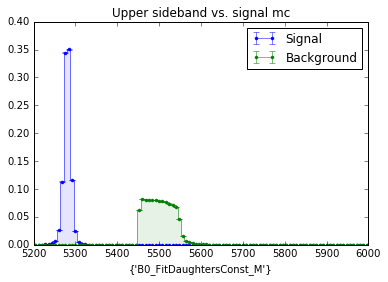

In [29]:
dataframe_names = ['Signal', 'Background']
plot_vars = ['B0_FitDaughtersConst_M']
plot_names = ['Upper sideband vs. signal mc']
dataframe_list = [signal_dataframe, bkg_dataframe]
plotter = Plotter()
plotter.create_plots(dataframe_list, plot_vars, None, plot_names , dataframe_names)
plotter['Upper sideband vs. signal mc'].set_range(5200, 6000)
p = Plotter('/home/chasenberg/plots/selection/')
plotter.plot()

Declare bdt features and correlation matrix and monte-carlo agreement
---------------------------------------------------------------------------------

In [30]:
bdt_features = [
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
#'B0_FitDaughtersConst_J_psi_1S_IP',   
#'B0_FitDaughtersConst_KS0_P1_PT',
#'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_min_PT',
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitPVConst_KS0_tau_dimless',
#'test_IP',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
#'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

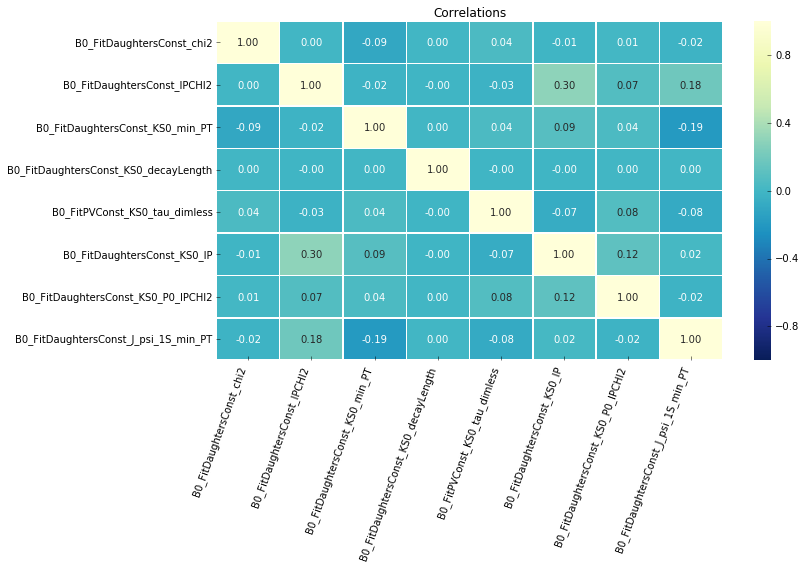

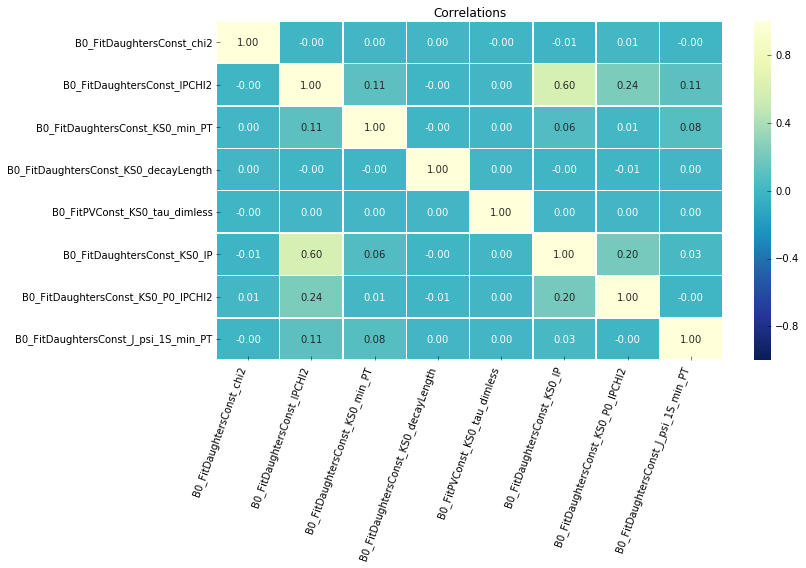

Done!


In [31]:
plt.figure(figsize=(12,8))
plot_correlations(bkg_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/selection/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/selection/correlation_mc.png')
plt.show()
print('Done!')

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [32]:
real_dataframe['SigYield_sw'].sum()

235929.9845763061

In [33]:
'''#Check bdt-variables in downstream events
mc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())
signal_dataframe['mc_weight'] = mc_weight
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/bdt_check/')
    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.99))
    #plotter[feature].set_range(0,20)
    plotter.plot()'''

"#Check bdt-variables in downstream events\nmc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())\nsignal_dataframe['mc_weight'] = mc_weight\nfor feature in bdt_features:\n    plotter = Plotter('/home/chasenberg/plots/bdt_check/')\n    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']\n    ,component_labels=['sWeighted data','Signal-MC'])\n    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.99))\n    #plotter[feature].set_range(0,20)\n    plotter.plot()"

Train GradienBoost classifier
====================================================================

In [34]:
flags = np.array([1]*len(signal_dataframe)+[0]*len(bkg_dataframe))
dataframe = pd.concat([signal_dataframe, bkg_dataframe])

In [35]:
signal_dataframe.shape, bkg_dataframe.shape,dataframe.shape

((1036779, 54), (1054296, 29), (2091075, 55))

In [36]:
#Apply Track Type cuts piminus_TRACK_Type

In [37]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=150,learning_rate=0.2)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           1.2045           14.71m
         2           1.0798           13.84m
         3           0.9894           14.09m
         4           0.9203           13.62m
         5           0.8685           13.20m
         6           0.8262           12.97m
         7           0.7944           12.96m
         8           0.7693           12.95m
         9           0.7464           12.75m
        10           0.7274           12.57m
        20           0.6227           11.43m
        30           0.5837           10.33m
        40           0.5667            9.42m
        50           0.5572            8.44m
        60           0.5516            7.55m
        70           0.5480            6.66m
        80           0.5430            5.79m
        90           0.5389            4.96m
       100           0.5370            4.11m


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [38]:
dataframe.shape

(2091075, 55)

Classifier performance
-----------------------

In [39]:
classifier.score(test_dataframe, test_flags)

0.88629777205610893

In [40]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_FitDaughtersConst_IPCHI2: 0.1857
B0_FitDaughtersConst_J_psi_1S_IPCHI2: 0.1759
B0_BKGCAT: 0.1645
B0_FitDaughtersConst_J_psi_1S_P1_PT: 0.1213
B0_FitDaughtersConst_J_psi_1S_IP: 0.1061
B0_FitDaughtersConst_J_psi_1S_min_PT: 0.0920
B0_FitDaughtersConst_KS0_IP: 0.0793
B0_FitDaughtersConst_J_psi_1S_P0_PT: 0.0751


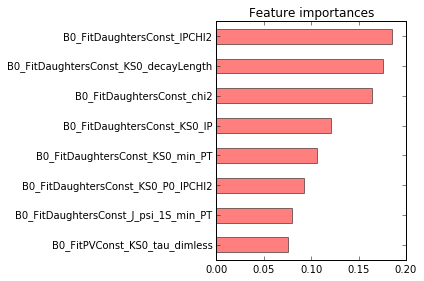

In [41]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/selection/feature_importance.png', bbox_inches='tight')

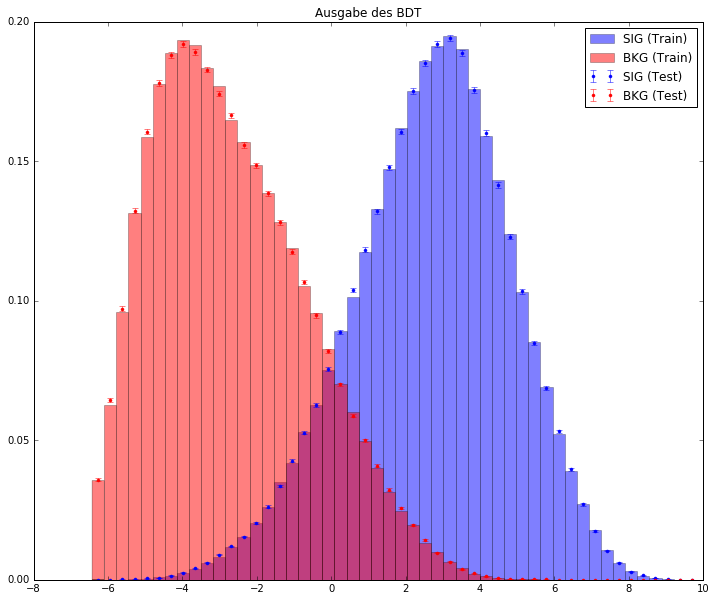

In [42]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/selection/overtraining.png')
plt.show()


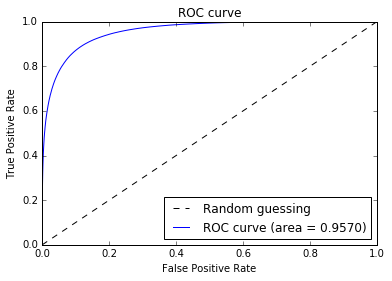

In [43]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/selection/roc_curve.png')




Classify unseen Data
============================================

In [44]:
variables_unseen = [
'B0_M',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',    
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_MinIPCHI2anyPV',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_FitPVConst_IPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'idxEventNumber',
'idxRunNumber',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_PV_X_flat',
'B0_FitPVConst_PV_XVAR_flat',
'B0_FitPVConst_PV_Y_flat',
'B0_FitPVConst_PV_YVAR_flat',
'B0_FitPVConst_PV_Z_flat',
'B0_FitPVConst_PV_ZVAR_flat',
]

unseen_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_data.root'
unseen_df = rp.read_root(unseen_dir,key=tree_data, columns=variables_unseen,where=cut_string_data, flatten=False)
unseen_df = unseen_df.replace([np.inf, -np.inf], np.nan)
unseen_df = unseen_df.dropna()

np.random.seed(42)
unseen_df['idxRandom'] = np.random.choice(2**30, unseen_df.shape[0])  
unseen_df['idxEventNumber'] = unseen_df['eventNumber'] 

In [45]:
#add symmetrical variables to dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(unseen_df, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(unseen_df, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(unseen_df, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate bkg_dataframedimensionless decay-time distribution
unseen_df['B0_FitPVConst_KS0_tau_dimless'] = unseen_df['B0_FitPVConst_KS0_tau']/unseen_df['B0_FitPVConst_KS0_tauErr']

In [46]:
#apply classifier to data and MC
classify_unseen_data([classifier], unseen_df, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], signal_dataframe_wrongPV, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], signal_dataframe, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], bkg_dataframe, bdt_features, 'BDTresponse')

/home/chasenberg/repos/dopy/dolearn/sklearn_utils.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[decision_column] = decision_vector


Write dataframe with BDT output to ROOT file
-------------------------------

In [47]:
efficiency = signal_dataframe.query('BDTresponse>0.48').shape[0] / signal_dataframe.shape[0]
print(efficiency)

0.8455369948658297


In [60]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/Bd2JpsimumuKS_mc_2015_2016_selected.root',key='Bd2JpsiKs')

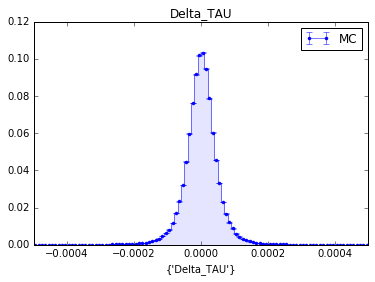

In [49]:
signal_dataframe_wrongPV[signal_dataframe_wrongPV['BDTresponse']>0.62]['Delta_TAU']
p = Plotter('/home/chasenberg/plots/selection/')
p.create_plots(signal_dataframe_wrongPV,'Delta_TAU',component_labels=['MC'])
p['Delta_TAU'].set_range(-0.0005,0.0005)
#bdt_plot.plot()
p.plot()

In [50]:
signal_dataframe_wrongPV.query('(Delta_TAU<-0.0007|Delta_TAU>0.0007)&B0_FitPVConst_MinIPCHI2anyPV_flat>20').shape[0]

4377

In [51]:
eff = signal_dataframe_wrongPV.query('abs(Delta_TAU)<0.0002').shape[0] / signal_dataframe_wrongPV.shape[0]
print(eff)

0.9868242924355153


Calculate simple FOM
---------------------------

In [52]:
bdt_cuts = np.linspace(-6,6,60)
fom_arr = []
for cut in bdt_cuts:
    nevents_after_bdt_dbkg = len(bkg_dataframe[bkg_dataframe['BDTresponse']>cut])
    nevents_after_bdt_signal = len(signal_dataframe[signal_dataframe['BDTresponse']>cut])
    fom = nevents_after_bdt_signal  / np.sqrt(nevents_after_bdt_dbkg+nevents_after_bdt_signal)
    fom_arr.append(fom)

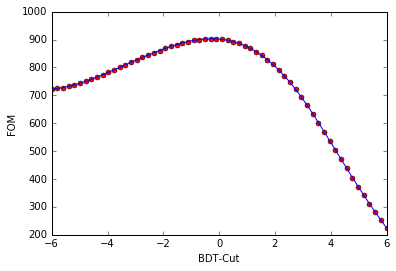

In [53]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(bdt_cuts, fom_arr,k=4, s=0)
spl.set_smoothing_factor(0.5)
plt.plot(bdt_cuts, fom_arr, 'ro', ms=5)
plt.plot(bdt_cuts,spl(bdt_cuts),'b')
plt.xlabel("BDT-Cut")
plt.ylabel("FOM")
plt.savefig('/home/chasenberg/plots/selection/effective_signalsize.png')

In [54]:
#Maximum of FOM
bdt_cut = spl.derivative().roots()[0]

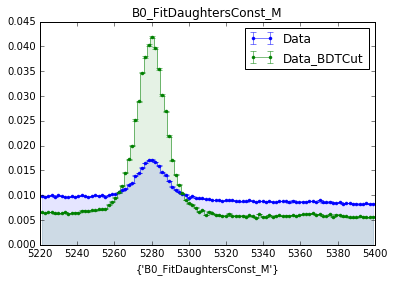

Efficiency of the cut: 0.44218050584408836
Number of Signalevents: 1488667


In [55]:
#Plot realdata with bdt cuts 
test =  unseen_df[unseen_df['BDTresponse']>bdt_cut]
p = Plotter('/home/chasenberg/plots/selection/')
p.create_plots([unseen_df,test],'B0_FitDaughtersConst_M',component_labels=['Data','Data_BDTCut'])
p['B0_FitDaughtersConst_M'].set_range(5220, 5400)
#bdt_plot.plot()
p.plot()
efficiency = len(test) / len(real_dataframe)
n_sig = unseen_df[unseen_df['BDTresponse']>bdt_cut].shape[0]
print("Efficiency of the cut:",efficiency)
print("Number of Signalevents:",n_sig)

Compare data without triggerline requirements against selected data
-----------------------------------------------------------

In [56]:
test.shape,real_dataframe.shape,unseen_df.shape

((1488667, 45), (3366650, 37), (8327165, 45))

In [57]:
#Write test-dataframe to root file 
unseen_df.query("BDTresponse>0.48&((abs(1115.683-varLambda0MassHypo_ppluspiminus)>10)|piplus_ProbNNp<0.05)&((abs(1115.683-varLambda0MassHypo_pminuspiplus)>10)|(piminus_ProbNNp<0.05))").to_root('/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_data_BDTresponse_cut_multiplepvs.root',key='Bd2JpsiKs')

In [58]:
#check efficiency
eff = signal_dataframe[signal_dataframe['BDTresponse']>2].shape[0] / signal_dataframe.shape[0]
print(eff)

0.6434129163495789


Check efficiencies for bdt cut
=========================================

In [59]:
nevents_before_bdt = len(signal_dataframe)
print('ne£vents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(signal_dataframe.query('BDTresponse>0.2'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT signal efficiency: ' + str(nevents_after_bdt/nevents_before_bdt))

ne£vents before BDT cut: 1036779
nevents after BDT cut: 903454
BDT signal efficiency: 0.8714046098541733


##### nevents_before_bdt = len(bkg_dataframe)
print('nevents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(bkg_dataframe.query('BDTresponse>0.67'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT background rejection: ' + str(1-nevents_after_bdt/nevents_before_bdt))